# **Projeto 2 introdução a redes neurais - Modelo não supervisionado**

--------------------

## Objetivo: 

Implementar uma rede neural não supervisionada (e.g., SOM ou GNG) em pelo menos dois datasets, avaliar os padrões detectados em cada conjunto como custers e outliers. Avaliar a qualidade dos agrupamentos variando parâmetros como número de neurônios, taxas de aprendizado e grid.

## Importando bibliotecas necessárias

In [1]:
import numpy as np
import seaborn as sns
import cv2
import os 
import matplotlib.pyplot as plt
from collections import Counter
import random
import matplotlib.gridspec as gridspec

# Configuração do Searborn
sns.set(
    style='darkgrid',
    context='notebook',
    rc={
        'axes.spines.top': False,
        'axes.spines.right': False
    }
)

## Primeiro Dataset

O primeiro dataset é o Chest X-ray images (Pneumonia), é um dataset do *kaggle* (`https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia`) que contém 5856 imagens de raios-X de tórax, dividas em duas classes: pneumonia (bacteriana e viral) e sem pneumonia (normal). As imagens foram rotuladas manualmente.  

## Preparação dos dados

### As seguintes etapas serão realizadas: 
 - Leitura das imagens: As imagens são divididas em pastas com as classes "PNEUMONIA" e "NORMAL".
 - Redimensionamento: Cada imagem é redimensionada para um tamanho fixo.
 - Transformação: As imagens são achatadas em vetores para o processamento da rede.
 - Codificação de rótulos: As classes são convertidas para valores binários.

In [2]:
# Caminhos para os dados de treino/teste 

diretorio_treino = "./train"
diretorio_teste = "./test"

A biblioteca `os` será utilizada para navegar pelas pastas e acessar os arquivos. A função `os.listdir()` lista os arquivos dentro de um diretório especificado, enquanto `os.path.join()` é usada para construir caminhos de arquivos de maneira compatível com diferentes sistemas operacionais, garantindo a integridade do código em diferentes plataformas, já para a preparação das imagens a biblioteca OpenCV (cv2) será usada para carregar e pré-processar as imagens. A função `cv2.imread()` lê a imagem e a converte para escala cinza, enquanto `cv2.resize()` redimensiona todas as imagens para um tamanho uniforme. Em seguida, a imagem é achatada com o `img.flatten()` para transforma-lá em um vetor

In [3]:
def carregar_imagens(diretorio, tamanho=(64, 64)): 
    """ 
    Função para carregar e preprocessar as imagens do diretório. 
    
    Parâmetros: 
    - diretorio: Caminho para o diretório contendo as imagens.
    - tamanho: Tamanho para o qual as imagens serão redimensionadas (64x64).
    
    Retorna: 
    - imagens: Array numpy com as imagens transformadas em vetores.
    - rotulos_imagens: Array numpy com os rótulos (0 para "NORMAL" e 1 para "PNEUMONIA").
    """

    # Listas para armazenar as imagens e seus respectivos rótulos
    imagens = []
    rotulos_imagens = []

    # Loop para percorrer as pastas de imagens ("PNEUMONIA" e "NORMAL") dentro do diretório
    for rotulo in os.listdir(diretorio): 
        pasta_rotulo = os.path.join(diretorio, rotulo)  # Caminho completo da pasta de rótulo
        # Loop para percorrer os arquivos dentro da pasta de rótulo
        for arquivo in os.listdir(pasta_rotulo): 
            caminho = os.path.join(pasta_rotulo, arquivo)  # Caminho completo da imagem
            # Ler a imagem em escala cinza
            imagem = cv2.imread(caminho, cv2.IMREAD_GRAYSCALE)
            # Redimensionar a imagem
            imagem = cv2.resize(imagem, tamanho)
            # Achatar a imagem para um vetor
            imagens.append(imagem.flatten())
            # Codificação dos rótulos, 0 : NORMAL, 1 : PNEUMONIA
            rotulos_imagens.append(0 if rotulo == "NORMAL" else 1)

    # Retorna as imagens e os rótulos como arrays numpy
    return np.array(imagens), np.array(rotulos_imagens) 

# Carregar as imagens de treino e teste usando a função 'carregar_imagens'
dados_treino, rotulos_treino = carregar_imagens(diretorio_treino)
dados_teste, rotulos_teste = carregar_imagens(diretorio_teste)

# Teste de verificação dos dados
print(f"Distribuição de rótulos: {np.unique(rotulos_teste, return_counts=True)}")

Distribuição de rótulos: (array([0, 1]), array([234, 390]))


## Aprendizado não supervisionado

A rede SOM utiliza aprendizado não supervisionado, que identifica padrões nos dados sem precisar de rótulos ou supervisão. Ela aproveita a redundância presente nos dados para organizar informações em um espaço mais simples.

## Aprendizado competitivo

O aprendizado competitivo, usado na rede SOM, faz os neurônios competirem para se ativar com base no padrão de entrada. Apenas o neurônio vencedor e seus vizinhos têm seus pesos ajustados, organizando os dados e identificando padrões.

## Self-Organizing Maps (SOM)

A rede SOM é um modelo neural inspirado na organização topológica do córtex cerebral, como os córtices visual, auditivo e motor. Utilizando aprendizado competitivo, ela organiza os neurônios em um grid (geralmente 2D), onde unidades próximas no mapa respondem a estímulos semelhantes. Durante o treinamento, o processo envolve três etapas principais: competição (os neurônios competem para ativar), cooperação (os vizinhos do neurônio vencedor se organizam) e adaptação sináptica (ajuste dos pesos para refletir os padrões de entrada). 

### Fase da competição

A fase de competição na rede SOM ocorre quando, para cada padrão de entrada, os neurônios da rede calculam seus respectivos valores com base em uma função discriminante. Essa função determina qual neurônio é mais "próximo" do padrão de entrada. O neurônio que apresentar o melhor resultado é o BMU (Best Matching Unit), ou a unidade de melhor correspondência, e é declarado o vencedor da competição. O BMU é o neurônio que mais se adapta ao padrão de entrada.

O processo competitivo é dado por: 

- vetor de entrada : $x = [x_1, x_2, \dots, x_m]$
- Rede (pesos dos neurônios): $W_j = [w_{j1}, w_{j2}, \dots, w_{jm}]$
- Neurônio vencedor (para todo j): $i(x) = \arg \min || x - w_j ||$

### Fase da cooperação 

A fase de cooperação na rede SOM ocorre quando o neurônio vencedor (BMU) determina a localização de uma vizinhança topológica de neurônios próximos. Esses neurônios vizinhos se beneficiam da ativação do neurônio vencedor. O neurônio vencedor $i(x)$ está no centro dessa região (vizinhança), e a vizinhança é definida pela proximidade no grid, não pelo conjunto de pesos. A função de vizinhança é dada por $h_{j,i}(x) = \exp \left( -\frac{d_{j,i}^2}{2 \sigma^2} \right)$, onde $d{j,i}$ é a distância entre os neurônios j e i. O decaimento da vizinhança é descrito por: $\sigma(t) = \sigma_0 \exp \left( -\frac{t}{\tau_{\text{}}} \right)$, com $\sigma(0)$ como o valor inicial e $\tau$ como o tempo de aprendizagem

### Fase de ajuste (adaptação)

É o processo em que os neurônios ajustam seus pesos para se adaptar ao padrão de entrada. O ajuste é dado pela fórmula:

$$W_j(t + 1) = W_j(t) + \eta(t) \cdot h_{j,i}(x)(t) \cdot (x - W_j)$$

Onde:

- $\eta(t)$ é o parâmetro de taxa de aprendizado.
- $h_{j,i}(x)(t)$ é a função de vizinhança em torno do neurônio vencedor.

O decaimento da taxa de aprendizado segue a fórmula: 

$$ \mu(t) = \mu_0 \exp\left(-\frac{t}{\tau_\mu}\right) $$


Onde:

- $\mu_0$ é a taxa de aprendizado inicial.
- $\tau_\mu$ é o tempo de decaimento.

### Aprendizado

Após diversas iterações e apresentações dos dados de treinamento, os pesos sinápticos ajustam-se para refletir a distribuição do vetor de entrada. Esse ajuste ocorre devido à atualização baseada na vizinhança topológica. Como resultado, o algoritmo promove uma ordenação topológica no mapa, onde neurônios adjacentes no grid possuem vetores de pesos similares.

A definição da função de vizinhança ($\sigma$) é um componente essencial para garantir a formação dessa ordenação no mapa auto-organizável.

### Considerações

O treinamento nas redes SOM é realizado em duas fases principais:

- Fase de Organização/Ordenação Topológica:
    - Nessa etapa inicial, o mapa é organizado de forma que os neurônios se ajustem para representar a topologia dos dados de entrada.

- Fase de Ajuste Fino (Convergência/Especialização):
    - Nesta fase, os pesos sinápticos são ajustados de maneira mais precisa para especializar os neurônios em padrões específicos.

Além disso, o treinamento envolve ajustes dinâmicos de:

- Taxa de Aprendizagem ($\eta$): Decai gradualmente para controlar a velocidade de adaptação.
- Função (Raio) de Vizinhança ($\sigma$): Reduz com o tempo para refinar a influência entre os neurônios.

## Implementação

A blblioteca usada para implementar a rede SOM (Self-Organizing Map) neste projetos será a MiniSom(`https://github.com/JustGlowing/minisom`), uma implementação simples do algoritmo SOM em Python

In [4]:
from minisom import MiniSom # Importando a classe MiniSom
from sklearn.metrics import accuracy_score  # Importando accuracy_score, utilizado para calcular a acurácia entre os rótulos previstos e os rótulos reais.

### Primeiro modelo

O primeiro modelo da rede SOM foi configurado com um grid de 4x4 (totalizando 16 neurônios), uma taxa de aprendizado de 0,005 e um valor de sigma (raio de vizinhança que ajusta a área ao redor do neurônio vencedor) de 0.5. O modelo foi treinado por apenas 10 épocas. 

In [5]:
# input_len é o número de características de entrada (número de pixels da imagem após o pré-processamento)
primeiro_modelo_som = MiniSom(x=4, y=4, input_len=dados_teste.shape[1], sigma=0.5, learning_rate=0.005)

In [6]:
# Inicializando os pesos da rede SOM com valores aleatórios baseados nos dados de treino
primeiro_modelo_som.random_weights_init(dados_teste)

# Treinando o modelo utilizando o método de treino em batch, passando os dados de treino 
primeiro_modelo_som.train_batch(dados_treino, num_iteration=10)

Acurácia: 0.73


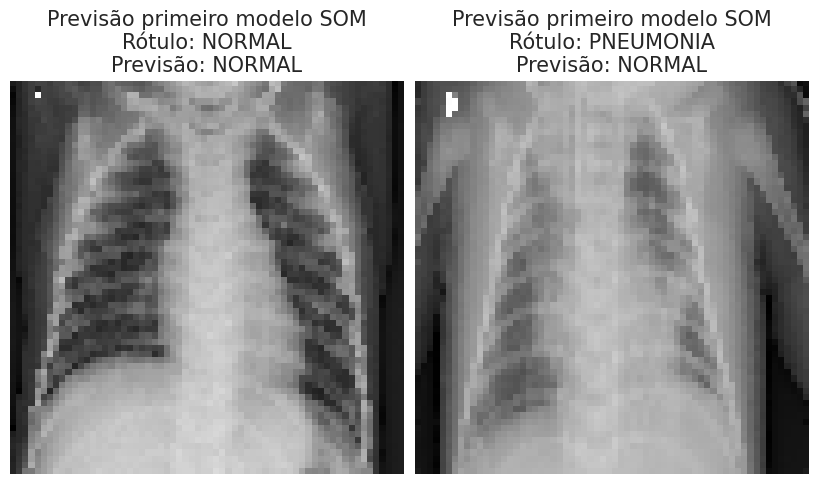

In [7]:
# Obter os neurônios vencedores como tuplas
previsao = [tuple(primeiro_modelo_som.winner(i)) for i in dados_treino]
# Dicionário para associar clusters (neurônios) aos rótulos dominantes
clusters = {}

# Itera sobre cada cluster (neurônio vencedor único) identificado
for cluster in set(previsao): 
    # Encontra os índices de todos os dados associados ao neurônio vencedor atual
    indices = [i for i, vencedor in enumerate(previsao) if vencedor == cluster]
    # Conta a frequência dos rótulos verdadeiros dos dados pertencentes a este cluster
    contagem_rotulos_cluster = Counter(rotulos_treino[indices])
    # Identifica o rótulo mais frequente no cluster atual
    rotulo_vencedor = contagem_rotulos_cluster.most_common(1)[0][0]
    # Associa o neurônio (cluster) ao rótulo dominante
    clusters[cluster] = rotulo_vencedor

# Fazer previsões com base nos clusters
previsoes = [tuple(primeiro_modelo_som.winner(i)) for i in dados_teste]
array_de_previsoes = np.array([clusters.get(vencedor, 0) for vencedor in previsoes])

# Calcular a acurácia 
acuracia = accuracy_score(rotulos_teste, array_de_previsoes)
print(f"Acurácia: {acuracia:.2f}")

# Previsões e rotulos_teste como arrays unidimensionais para plotar
previsoes = np.array(previsoes).flatten()
rotulos_teste = np.array(rotulos_teste).flatten()


# Listas para exemplos corretos e incorretos
corretos = []
incorretos = []

# Comparar previsões com rótulos e armazenar índices
for i in range(len(rotulos_teste)):
    if (previsoes[i] == 0 and rotulos_teste[i] == 0) or (previsao[i] == 1 and rotulos_teste[i] == 1):
        corretos.append(i)
    elif (previsoes[i] == 1 and rotulos_teste[i] == 0) or (previsoes[i] == 0 and rotulos_teste[i] == 1): 
        incorretos.append(i)

# Selecionar 1 exemplo correto e 1 incorreto
exemplos_selecionados = corretos[:1] + incorretos[:1]

# Plotar os exemplos 
_, plot = plt.subplots(1, len(exemplos_selecionados), figsize=(15, 5))

for i, j in zip(exemplos_selecionados, plot):
    j.imshow(dados_teste[i].reshape(64, 64), cmap="gray")
    j.set_title(
        f"Previsão primeiro modelo SOM\n"
        f"Rótulo: {'NORMAL' if rotulos_teste[i] == 0 else 'PNEUMONIA'}\n"
        f"Previsão: {'NORMAL' if previsoes[i] == 0 else 'PNEUMONIA'}",
        fontsize=15
    )
    j.axis("off")

plt.subplots_adjust(wspace=-0.9)
plt.tight_layout()

O primeiro modelo SOM alcançou uma acurácia satisfatória, utilizando uma configuração inicial simples: 16 neurônios em um grid 4x4, taxa de aprendizado de 0,5% e sigma reduzido (0,5), com treinamento em apenas 10 épocas. Apesar de sua simplicidade, o modelo demonstrou eficiência na identificação de padrões nos dados.

### Proporção de amostras por classe em cada neurônio primeiro modelo SOM

A proporção de amostras por classe em cada neurônio associa visualmente as classes representadas. Isso é feito utilizando gráficos de setores para cada neurônio, permitindo compreender como o SOM organiza e distribui as classes no mapa.

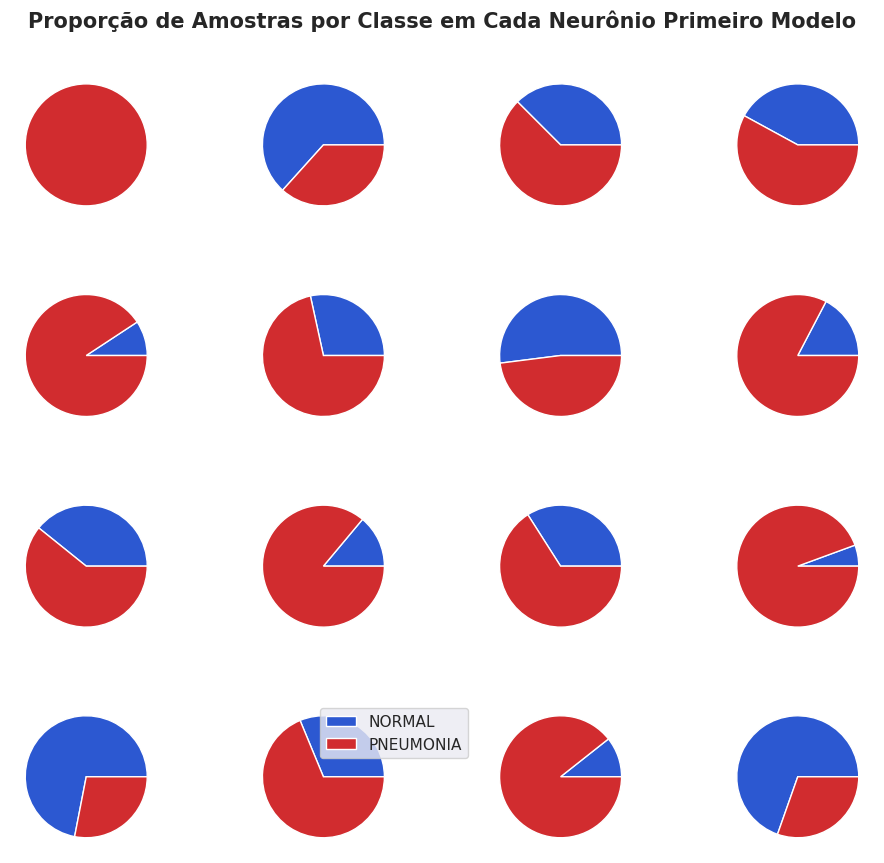

In [8]:
# Definição das classes 
nomes_rotulos = {0: 'NORMAL', 1: 'PNEUMONIA'}

# Obter o mapeamento de rótulos para os neurônios
mapa_rotulos = primeiro_modelo_som.labels_map(dados_treino, [nomes_rotulos[i] for i in rotulos_treino])

plot = plt.figure(figsize=(9, 9))
grid = gridspec.GridSpec(4, 4, plot)  # Grid para o SOM 4x4

# Loop para plotar os gráficos
for i in mapa_rotulos.keys():
    j = [mapa_rotulos[i].get(k, 0) for k in nomes_rotulos.values()]
    plt.subplot(grid[3 - i[1], i[0]], aspect=1)  
    plot, _ = plt.pie(j, colors = ['#2c58d1', '#d12c2f'] )

plt.legend(plot, nomes_rotulos.values(), bbox_to_anchor=(1.5, 1), loc="upper right", ncol=1)
plt.suptitle("Proporção de Amostras por Classe em Cada Neurônio Primeiro Modelo", fontsize=15, fontweight='bold')
plt.tight_layout()

### Erro de quantização do primeiro modelo

O erro de quantização mede a média das distâncias entre cada dado e o neurônio vencedor no SOM, indicando o quão bem os dados foram representados pelo modelo. Valores menores refletem maior qualidade no mapeamento dos padrões.

/home/gui/miniconda3/lib/python3.11/site-packages/minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)
/tmp/ipykernel_14652/3052485391.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


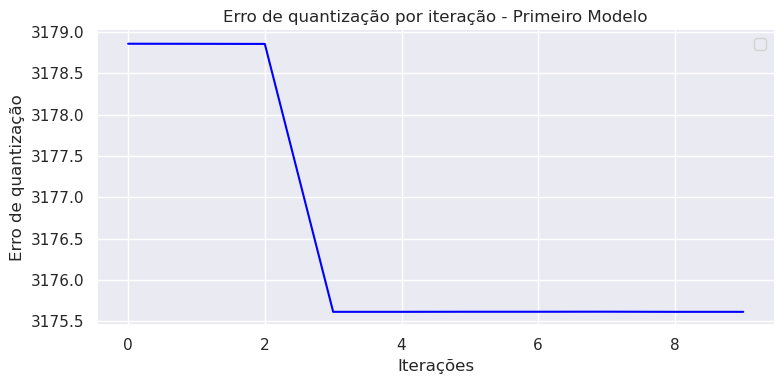

In [9]:
iteracoes = 10  # Número de iterações
q_erro = []  # Lista para armazenar o erro de quantização

# Treinamento e cálculo do erro de quantização
for i in range(iteracoes):
    rand = np.random.randint(len(dados_treino))  # Seleciona aleatoriamente uma amostra
    # Atualiza o modelo com a amostra aleatória
    primeiro_modelo_som.update(dados_treino[rand], 
                               primeiro_modelo_som.winner(dados_treino[rand]), 
                               i, iteracoes)
    # Calcula o erro de quantização
    q_erro.append(primeiro_modelo_som.quantization_error(dados_treino))

# Plotagem do erro de quantização
plt.figure(figsize=(8, 4))
plt.plot(np.arange(iteracoes), q_erro, color='blue')
plt.ylabel('Erro de quantização')
plt.xlabel('Iterações')
plt.title('Erro de quantização por iteração - Primeiro Modelo')
plt.legend()
plt.grid(True)
plt.tight_layout()

### Segundo modelo

O segundo modelo da rede SOM foi configurado com um grid de 8x8 (totalizando 64 neurônios), uma taxa de aprendizado de 1% e um valor de sigma (raio de vizinhança que ajusta a área ao redor do neurônio vencedor) de 1.5. O modelo foi treinado por 200 épocas. 

In [10]:
# input_len é o número de características de entrada (número de pixels da imagem após o pré-processamento)
segundo_modelo_som = MiniSom(x=8, y=8, input_len=dados_teste.shape[1], sigma=1.5, learning_rate=0.01)

In [11]:
# Inicializando os pesos da rede SOM com valores aleatórios baseados nos dados de treino
segundo_modelo_som.random_weights_init(dados_teste)

# Treinando o modelo utilizando o método de treino em batch, passando os dados de treino 
segundo_modelo_som.train_batch(dados_treino, num_iteration=200)

Acurácia: 0.76


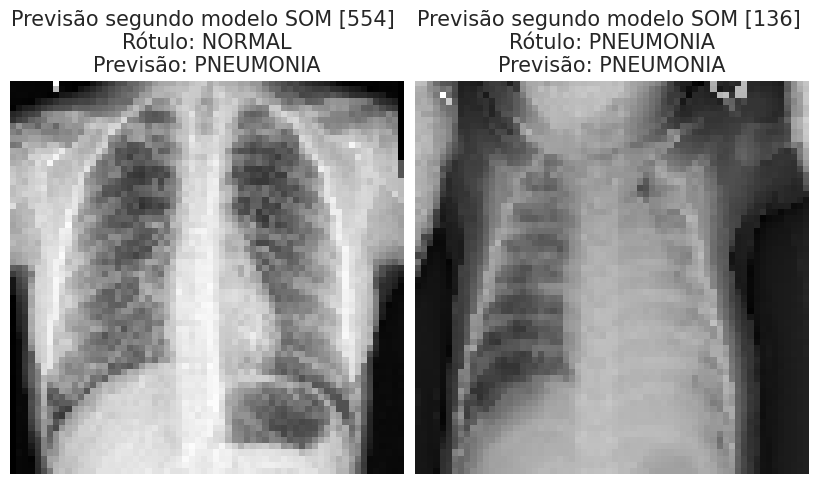

In [12]:
# Obter os neurônios vencedores como tuplas
previsao_2 = [tuple(segundo_modelo_som.winner(i)) for i in dados_treino]

# Dicionário para associar clusters (neurônios) aos rótulos dominantes
clusters_2 = {}

# Itera sobre cada cluster (neurônio vencedor único) identificado
for cluster_2 in set(previsao_2): 
    # Encontra os índices de todos os dados associados ao neurônio vencedor atual
    indices_2 = [i for i, vencedor_2 in enumerate(previsao_2) if vencedor_2 == cluster_2]
    # Conta a frequência dos rótulos verdadeiros dos dados pertencentes a este cluster
    contagem_rotulos_cluster_2 = Counter(rotulos_treino[indices_2])
    # Identifica o rótulo mais frequente no cluster atual
    rotulo_vencedor_2 = contagem_rotulos_cluster_2.most_common(1)[0][0]
    # Associa o neurônio (cluster) ao rótulo dominante
    clusters_2[cluster_2] = rotulo_vencedor_2

# Fazer previsões com base nos clusters
previsoes_2 = [tuple(segundo_modelo_som.winner(i)) for i in dados_teste]
array_de_previsoes_2 = np.array([clusters_2.get(vencedor_2, 0) for vencedor_2 in previsoes_2])

# Calcular a acurácia 
acuracia_2 = accuracy_score(rotulos_teste, array_de_previsoes_2)
print(f"Acurácia: {acuracia_2:.2f}")

# Previsões array unidimensional para plotar
previsoes_2 = np.array(previsoes).flatten()

# Selecionar 2 exemplos aleatórios do segundo modelo
indices_aleatorios = random.sample(range(len(dados_teste)), 2)

# Plotar os exemplos
_, plot = plt.subplots(1, len(indices_aleatorios), figsize=(15, 5))

for i, j in zip(indices_aleatorios, plot):
    j.imshow(dados_teste[i].reshape(64, 64), cmap="gray") 
    j.set_title(
        f"Previsão segundo modelo SOM [{i}] \n"
        f"Rótulo: {'NORMAL' if rotulos_teste[i] == 0 else 'PNEUMONIA'}\n"
        f"Previsão: {'NORMAL' if previsoes[i] == 0 else 'PNEUMONIA'}",
        fontsize=15
    )
    j.axis("off")
    
plt.subplots_adjust(wspace=-0.9)
plt.tight_layout()

O segundo modelo SOM atingiu uma acurácia satisfatória com uma configuração de 64 neurônios em um grid 8x8, taxa de aprendizado de 1% e sigma de 1.5, treinado por 200 épocas. Essa configuração demonstrou eficiência na identificação de padrões nos dados.

### Proporção de amostras por classe em cada neurônio segundo modelo SOM

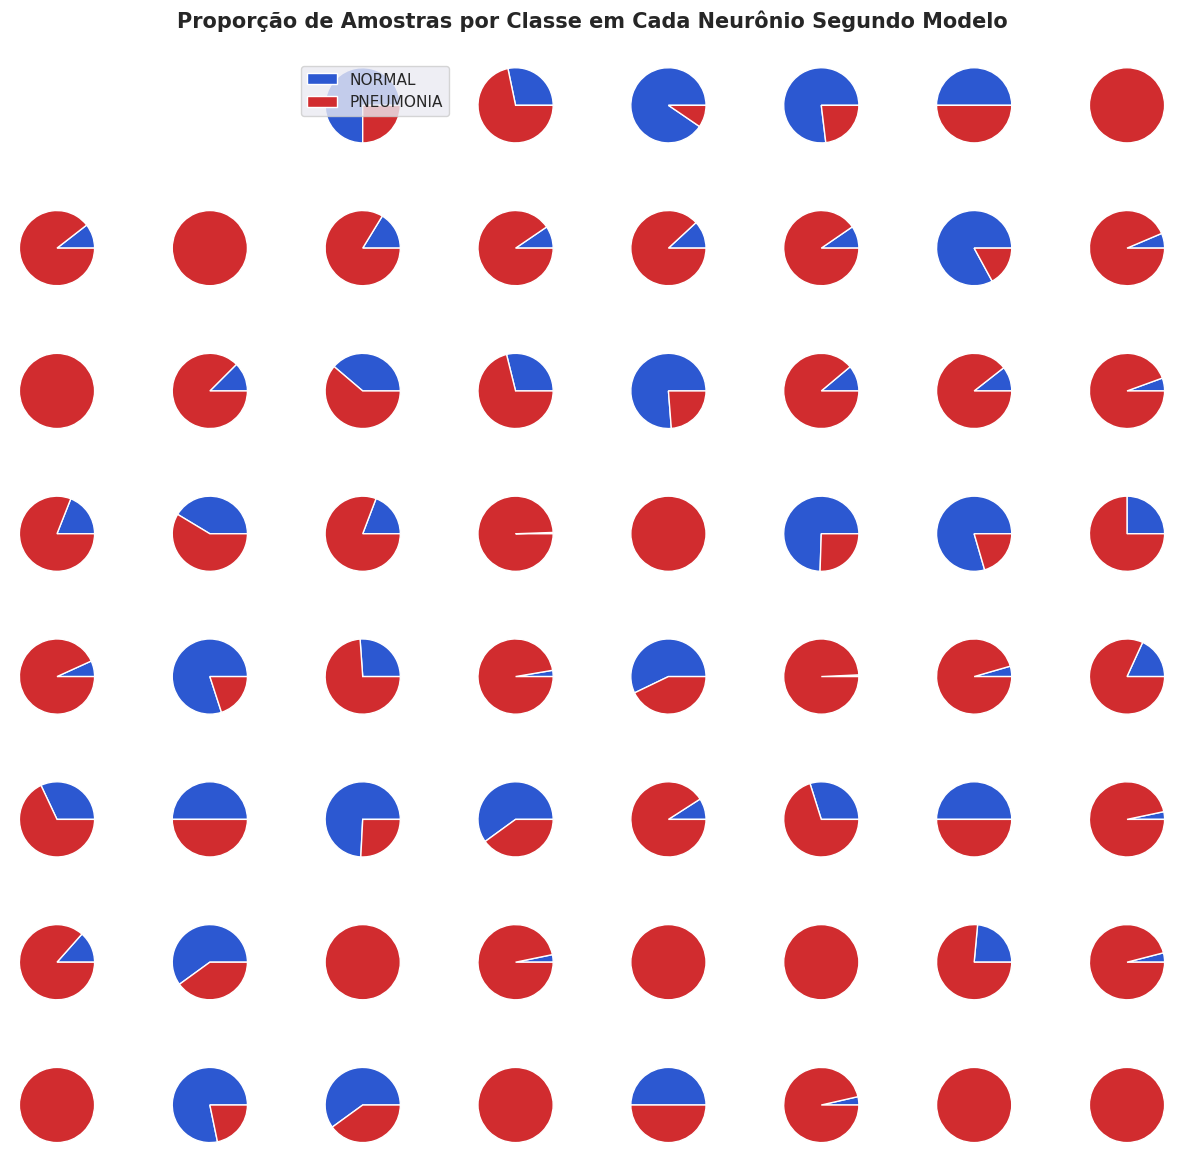

In [13]:
# Obter o mapeamento de rótulos para os neurônios
mapa_rotulos = segundo_modelo_som.labels_map(dados_treino, [nomes_rotulos[i] for i in rotulos_treino])

plot = plt.figure(figsize=(12, 12))
grid = gridspec.GridSpec(8, 8, plot)  # Grid para o SOM 8x8

# Loop para plotar os gráficos
for i in mapa_rotulos.keys():
    j = [mapa_rotulos[i].get(k, 0) for k in nomes_rotulos.values()]
    plt.subplot(grid[7 - i[1], i[0]], aspect=1)  
    plot, _ = plt.pie(j, colors=['#2c58d1', '#d12c2f'])

plt.legend(plot, nomes_rotulos.values(), bbox_to_anchor=(1.5, 1), loc="upper right", ncol=1)
plt.suptitle("Proporção de Amostras por Classe em Cada Neurônio Segundo Modelo", fontsize=15, fontweight='bold')
plt.tight_layout()

### Erro de quantização do segundo modelo

/home/gui/miniconda3/lib/python3.11/site-packages/minisom.py:513: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


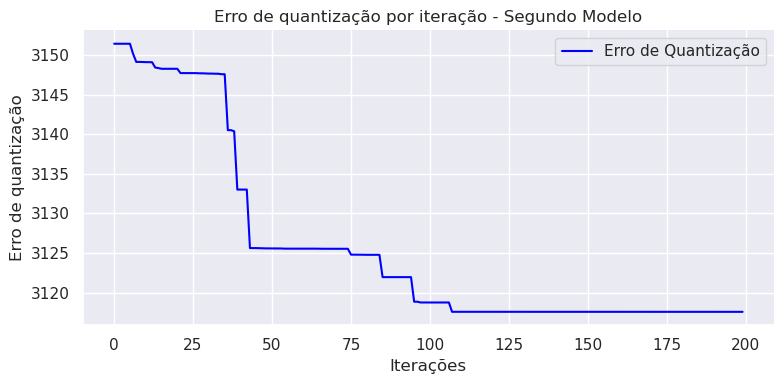

In [14]:
iteracoes = 200  # Número de iterações
q_erro = []  # Lista para armazenar o erro de quantização

# Treinamento e cálculo do erro de quantização
for i in range(iteracoes):
    rand = np.random.randint(len(dados_treino))  # Seleciona aleatoriamente uma amostra
    # Atualiza o modelo com a amostra aleatória
    segundo_modelo_som.update(dados_treino[rand], 
                              segundo_modelo_som.winner(dados_treino[rand]), 
                              i, iteracoes)
    # Calcula o erro de quantização
    q_erro.append(segundo_modelo_som.quantization_error(dados_treino))

# Plotagem do erro de quantização
plt.figure(figsize=(8, 4))
plt.plot(np.arange(iteracoes), q_erro, color='blue', label='Erro de Quantização')
plt.ylabel('Erro de quantização')
plt.xlabel('Iterações')
plt.title('Erro de quantização por iteração - Segundo Modelo')
plt.legend()
plt.grid(True)
plt.tight_layout()

## Segundo Dataset

Para o segundo dataset, será utilizado o Digits Dataset, que contém 1.797 imagens de dígitos manuscritos (de 0 a 9), representadas por matrizes 8x8 de pixels, totalizando 64 características por imagem. As imagens são rotuladas.

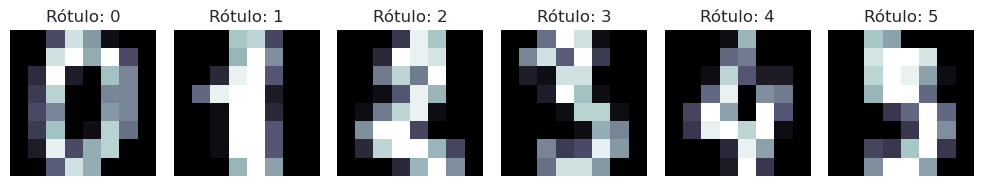

In [15]:
from sklearn.datasets import load_digits # Importar a classe load_digits 
from sklearn.model_selection import train_test_split # Importar a classe train_test_split

# Carregar o dataset de dígitos
digitos = load_digits()

# Dividir o dataset em dados de treino e teste(70%/30%)
dados_treino_2, dados_teste_2, rotulos_treino_2, rotulos_teste_2 = train_test_split(digitos.data, digitos.target, test_size=0.3)

# Plotar alguns exemplos do dataset
plt.figure(figsize=(10, 5))

for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(digitos.images[i], cmap="bone")
    plt.title(f"Rótulo: {digitos.target[i]}")
    plt.axis("off")

plt.tight_layout()

### Terceiro modelo SOM 

O terceiro modelo da rede SOM foi configurado com um grid de 5x5 (totalizando 25 neurônios), uma taxa de aprendizado de 0,05 e um valor de sigma (raio de vizinhança que ajusta a área ao redor do neurônio vencedor) de 1. O modelo foi treinado por 50 épocas. 

In [16]:
# input_len é o número de características de entrada (número de pixels da imagem)
terceiro_modelo_som = MiniSom(x=5, y=5, input_len=dados_teste_2.shape[1], sigma=1, learning_rate=0.05)

In [17]:
# Inicializando os pesos da rede SOM com valores aleatórios baseados nos dados de treino
terceiro_modelo_som.random_weights_init(dados_teste_2)

# Treinando o modelo utilizando o método de treino em batch, passando os dados de treino 
terceiro_modelo_som.train_batch(dados_treino_2, num_iteration=50)

Acurácia: 0.75


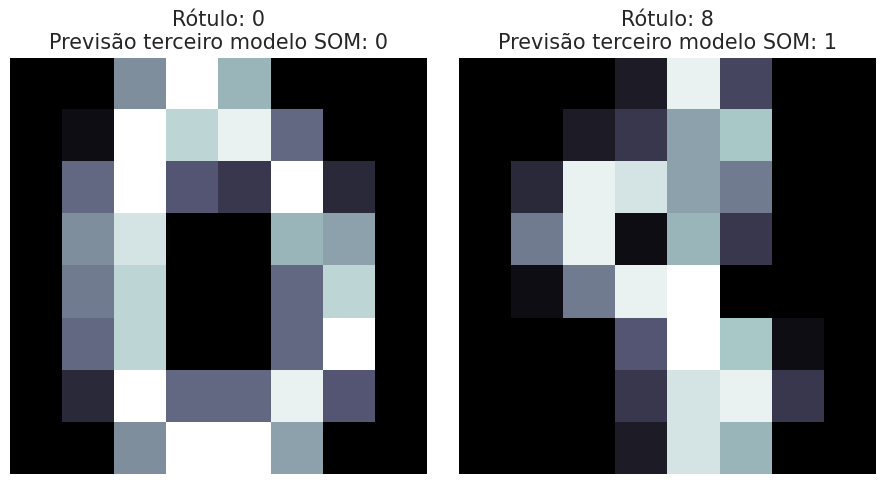

In [18]:
# Obter os neurônios vencedores como tuplas para os dados de treino
previsao_3 = [tuple(terceiro_modelo_som.winner(i)) for i in dados_treino_2]

# Dicionário para associar clusters (neurônios) aos rótulos dominantes
clusters_3 = {}

# Iterar sobre cada cluster (neurônio vencedor único) identificado
for cluster_3 in set(previsao_3):
    # Encontra os índices de todos os dados associados ao neurônio vencedor atual
    indices_3 = [i for i, vencedor in enumerate(previsao_3) if vencedor == cluster_3]
    # Conta a frequência dos rótulos verdadeiros dos dados pertencentes a este cluster
    contagem_rotulos_cluster_3 = Counter(rotulos_treino_2[indices_3])
    # Identifica o rótulo mais frequente no cluster atual
    rotulo_vencedor_3 = contagem_rotulos_cluster_3.most_common(1)[0][0]
    # Associa o neurônio (cluster) ao rótulo dominante
    clusters_3[cluster_3] = rotulo_vencedor_3

# Fazer previsões com base nos clusters para os dados de teste
previsoes_3 = [tuple(terceiro_modelo_som.winner(i)) for i in dados_teste_2]
array_de_previsoes_3 = np.array([clusters_3.get(vencedor_3, 0) for vencedor_3 in previsoes_3])

# Calcular a acurácia
acuracia_3 = accuracy_score(rotulos_teste_2, array_de_previsoes_3)
print(f"Acurácia: {acuracia_3:.2f}")

# Previsões e rótulos de teste como arrays unidimensionais para plotar
previsoes_3 = np.array(array_de_previsoes_3).flatten()
rotulos_teste_2 = np.array(rotulos_teste_2).flatten()

# Listas para armazenar exemplos corretos e incorretos
corretos_2 = []
incorretos_2 = []

# Comparar previsões com rótulos e armazenar índices
for i in range(len(rotulos_teste_2)):
    if previsoes_3[i] == rotulos_teste_2[i]:
        corretos_2.append(i)
    else:
        incorretos_2.append(i)

# Selecionar 1 exemplo correto e 1 incorreto
exemplos_selecionados_2 = corretos_2[:1] + incorretos_2[:1]

# Plotar os exemplos
_, plot = plt.subplots(1, len(exemplos_selecionados_2), figsize=(15, 5))

for i, j in zip(exemplos_selecionados_2, plot):
    j.imshow(dados_teste_2[i].reshape(8, 8), cmap="bone") 
    j.set_title(
        f"Rótulo: {rotulos_teste_2[i]}\n"
        f"Previsão terceiro modelo SOM: {previsoes_3[i]}",
        fontsize=15
    )
    j.axis("off")

plt.subplots_adjust(wspace=-0.8)
plt.tight_layout()

O terceiro modelo SOM alcançou uma acurácia considerável utilizando uma configuração com 25 neurônios dispostos em um grid de 5x5, taxa de aprendizado de 5% e sigma igual a 1, após 50 épocas de treinamento.

### Proporção de amostras por classe em cada neurônio terceiro modelo SOM

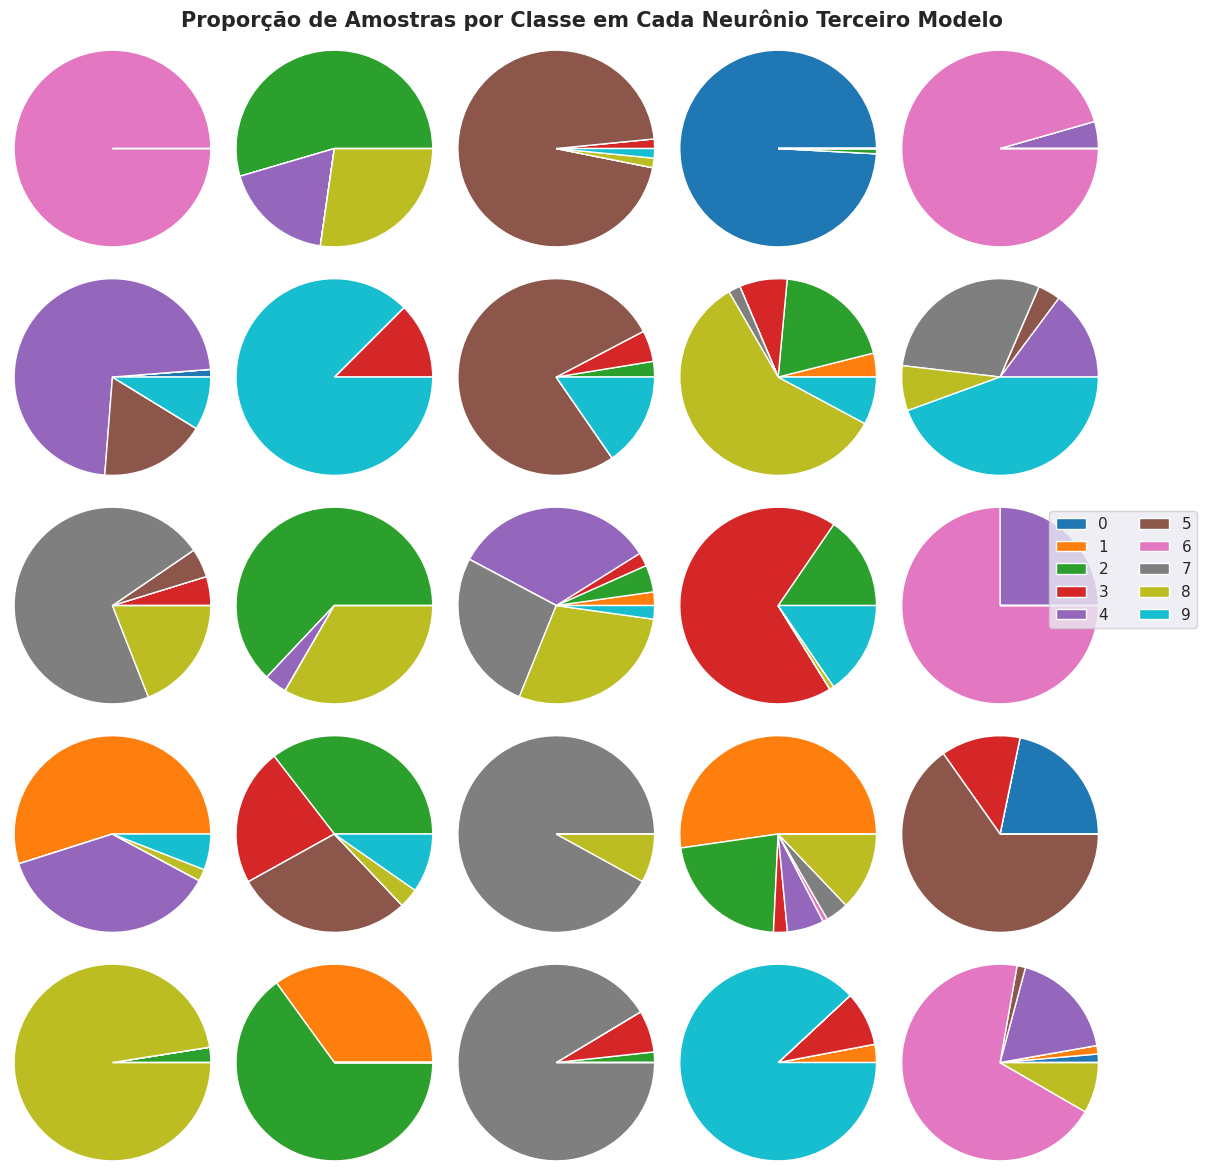

In [19]:
# Definir os rótulos das classes
nomes_rotulos_2 = {i: str(i) for i in range(10)}  # Classes de 0 a 9

# Obter o mapeamento de rótulos para os neurônios
mapa_rotulos_2 = terceiro_modelo_som.labels_map(dados_treino_2, [nomes_rotulos_2[i] for i in rotulos_treino_2])

plot = plt.figure(figsize=(12, 12))  
grid = gridspec.GridSpec(5, 5, plot)  # Grid para o SOM 5x5

# Loop para plotar os gráficos
for i in mapa_rotulos_2.keys():
    j = [mapa_rotulos_2[i].get(rotulo, 0) for rotulo in nomes_rotulos_2.values()]
    plt.subplot(grid[4 - i[1], i[0]], aspect=1)  
    plot, _ = plt.pie(j, colors=plt.cm.tab10.colors, radius=1.2)  

plt.legend(plot, nomes_rotulos_2.values(), bbox_to_anchor=(1.5, 1), loc="upper right", ncol=2)  
plt.suptitle("Proporção de Amostras por Classe em Cada Neurônio Terceiro Modelo", fontsize=15, fontweight='bold')
plt.tight_layout()

### Erro de quantização do terceiro modelo

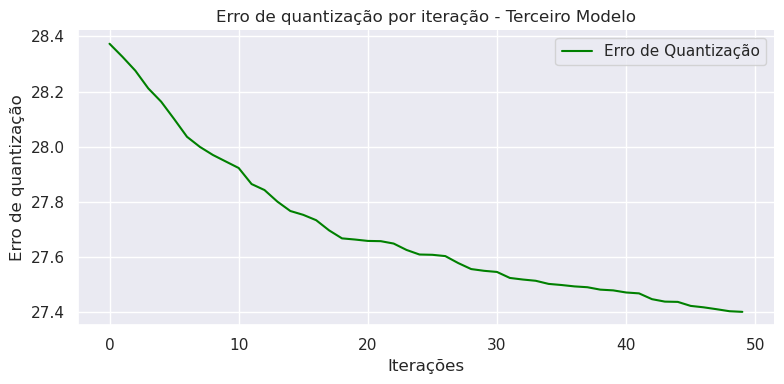

In [20]:
iteracoes = 50  # Número de iterações
q_erro = []  # Lista para armazenar o erro de quantização

# Treinamento e cálculo do erro de quantização
for i in range(iteracoes):
    rand = np.random.randint(len(dados_treino_2))  # Seleciona aleatoriamente uma amostra
    # Atualiza o modelo com a amostra aleatória
    terceiro_modelo_som.update(dados_treino_2[rand], 
                               terceiro_modelo_som.winner(dados_treino_2[rand]), 
                               i, iteracoes)
    # Calcula o erro de quantização
    q_erro.append(terceiro_modelo_som.quantization_error(dados_treino_2))

# Plotagem do erro de quantização
plt.figure(figsize=(8, 4))
plt.plot(np.arange(iteracoes), q_erro, color='green', label='Erro de Quantização')
plt.ylabel('Erro de quantização')
plt.xlabel('Iterações')
plt.title('Erro de quantização por iteração - Terceiro Modelo')
plt.legend()
plt.grid(True)
plt.tight_layout()

### Quarto modelo SOM

O quarto modelo da rede SOM foi configurado com um grid de 10x10 (totalizando 100 neurônios), uma taxa de aprendizado de 0,5 e um valor de sigma (raio de vizinhança que ajusta a área ao redor do neurônio vencedor) de 5. O modelo foi treinado por 200 épocas. 

In [21]:
# input_len é o número de características de entrada (número de pixels da imagem)
quarto_modelo_som = MiniSom(x=10, y=10, input_len=dados_teste_2.shape[1], sigma=5, learning_rate=0.5)

In [22]:
# Inicializando os pesos da rede SOM com valores aleatórios baseados nos dados de treino
quarto_modelo_som.random_weights_init(dados_teste_2)

# Treinando o modelo utilizando o método de treino em batch, passando os dados de treino 
quarto_modelo_som.train_batch(dados_treino_2, num_iteration=200)

Acurácia: 0.79


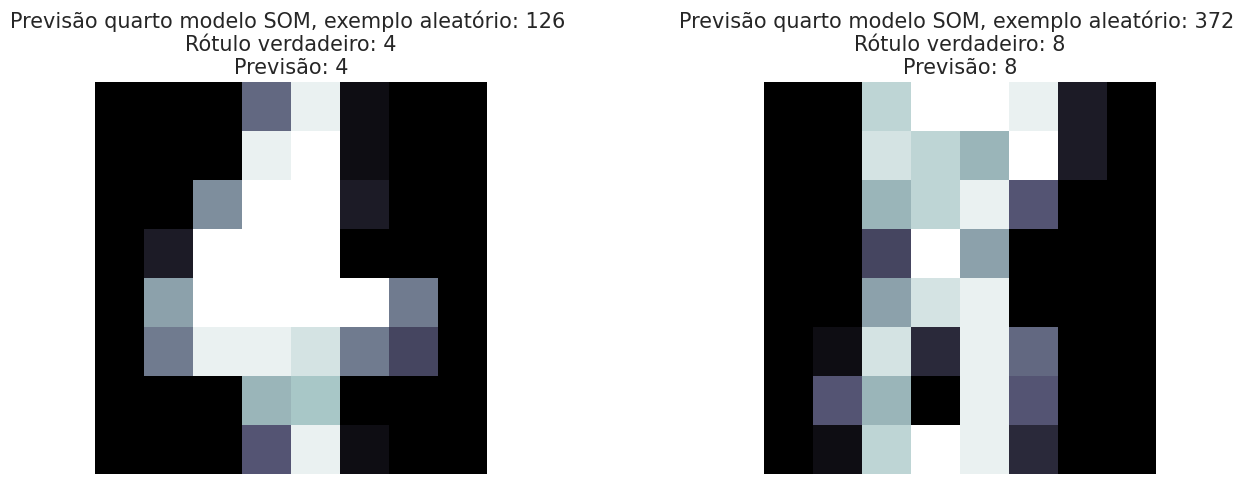

In [23]:
# Obter os neurônios vencedores como tuplas para os dados de treino
previsao_4 = [tuple(quarto_modelo_som.winner(i)) for i in dados_treino_2]

# Dicionário para associar clusters (neurônios) aos rótulos dominantes
clusters_4 = {}

# Iterar sobre cada cluster (neurônio vencedor único) identificado
for cluster_4 in set(previsao_4):
    # Encontra os índices de todos os dados associados ao neurônio vencedor atual
    indices_4 = [i for i, vencedor in enumerate(previsao_4) if vencedor == cluster_4]
    # Conta a frequência dos rótulos verdadeiros dos dados pertencentes a este cluster
    contagem_rotulos_cluster_4 = Counter(rotulos_treino_2[indices_4])
    # Identifica o rótulo mais frequente no cluster atual
    rotulo_vencedor_4 = contagem_rotulos_cluster_4.most_common(1)[0][0]
    # Associa o neurônio (cluster) ao rótulo dominante
    clusters_4[cluster_4] = rotulo_vencedor_4

# Fazer previsões com base nos clusters para os dados de teste
previsoes_4 = [tuple(quarto_modelo_som.winner(i)) for i in dados_teste_2]
array_de_previsoes_4 = np.array([clusters_4.get(vencedor_4, 0) for vencedor_4 in previsoes_4])

# Calcular a acurácia
acuracia_4 = accuracy_score(rotulos_teste_2, array_de_previsoes_4)
print(f"Acurácia: {acuracia_4:.2f}")

# Selecionar 2 exemplos aleatórios do quarto modelo
indices_aleatorios_2 = random.sample(range(len(dados_teste_2)), 2)

# Plotar os exemplos
_, plot = plt.subplots(1, len(indices_aleatorios_2), figsize=(15, 5))

for i, j in zip(indices_aleatorios_2, plot):
    j.imshow(dados_teste_2[i].reshape(8, 8), cmap="bone")  
    j.set_title(
        f"Previsão quarto modelo SOM, exemplo aleatório: {i} \n"
        f"Rótulo verdadeiro: {rotulos_teste_2[i]}\n"
        f"Previsão: {array_de_previsoes_4[i]}",
        fontsize=15
    )
    j.axis("off")

plt.tight_layout()

O quarto modelo SOM apresentou um desempenho ótimo ao ser configurado com 100 neurônios organizados em um grid de 10x10, taxa de aprendizado de 50% e sigma igual a 5. Esse modelo foi treinado por 200 épocas.

### Proporção de amostras por classe em cada neurônio quarto modelo SOM

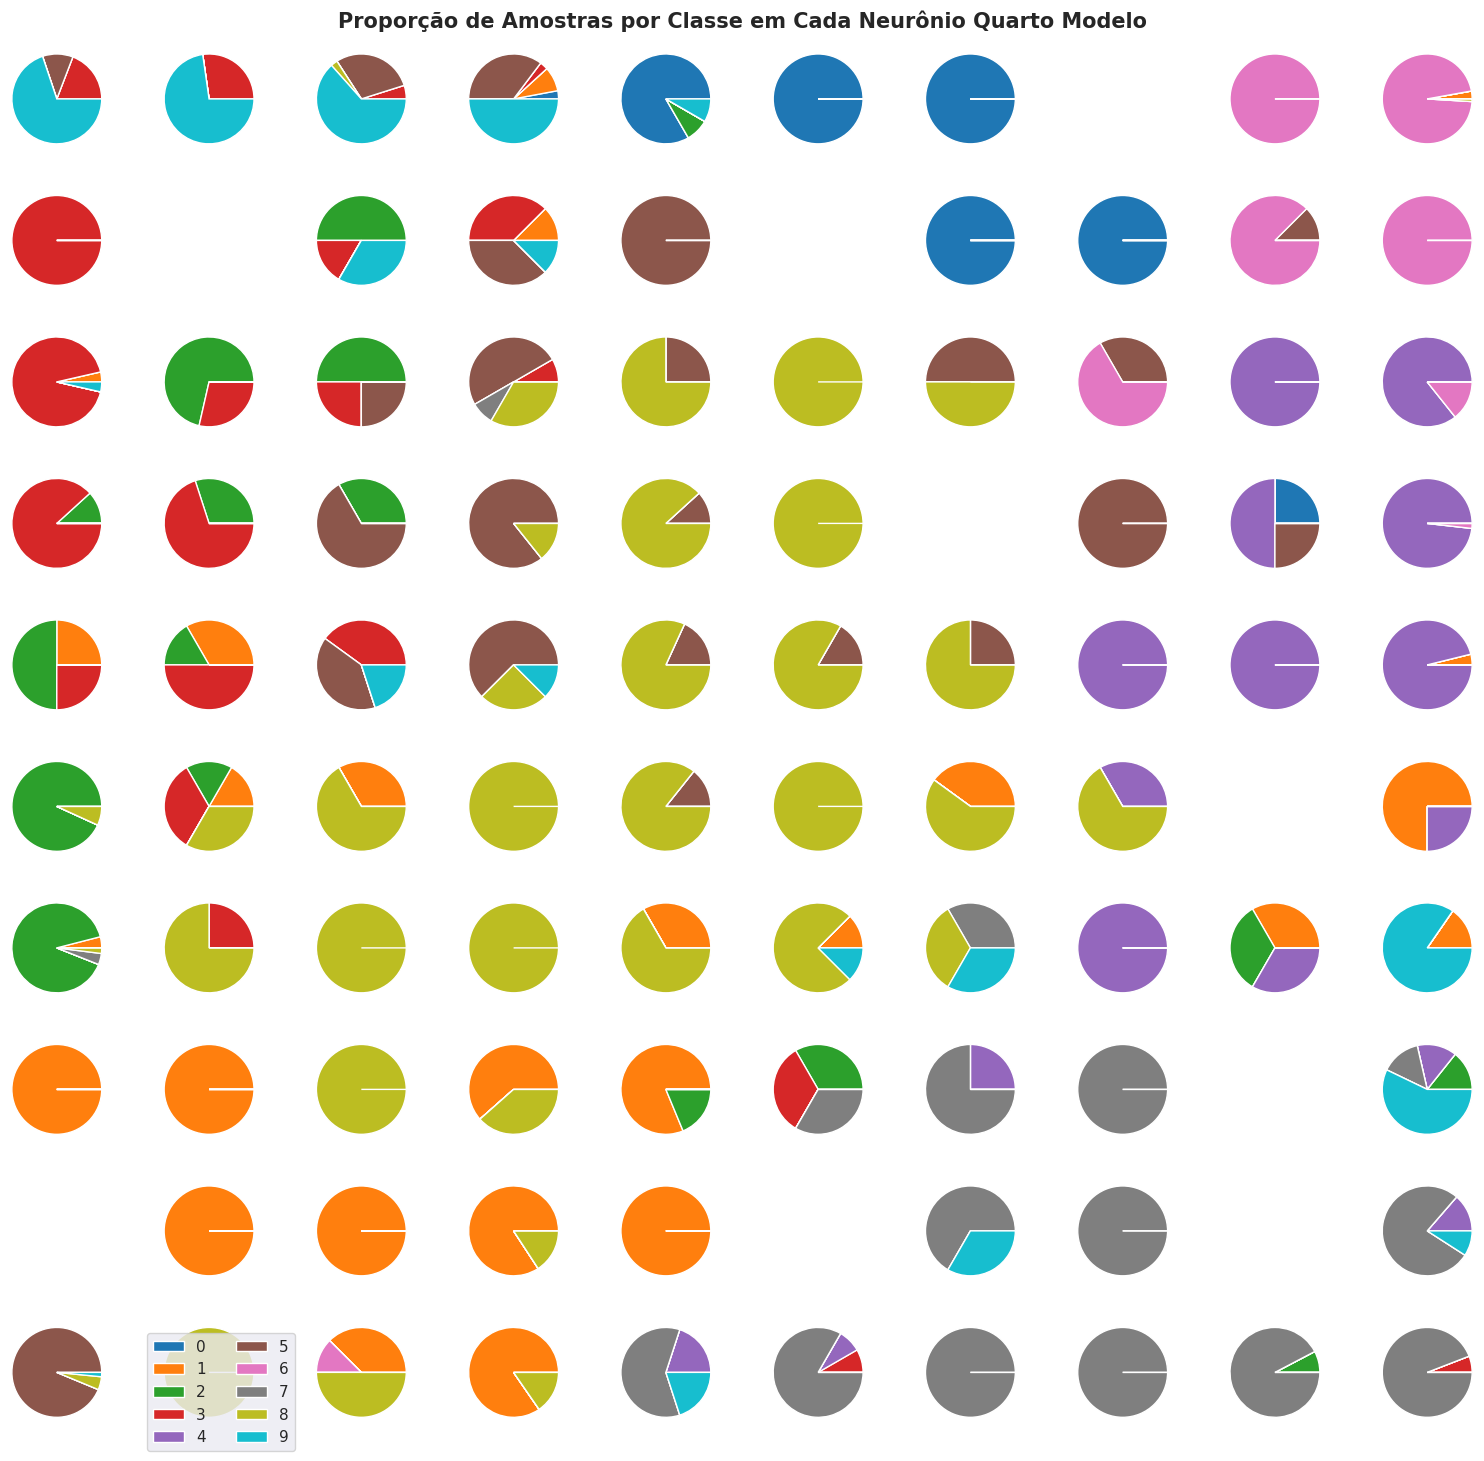

In [24]:
# Definir os rótulos das classes
mapa_rotulos_3 = quarto_modelo_som.labels_map(dados_treino_2, [nomes_rotulos_2[i] for i in rotulos_treino_2])

plot = plt.figure(figsize=(15, 15))  
grid = gridspec.GridSpec(10, 10, plot)  # Grid para o SOM 10x10

# Loop para plotar os gráficos
for i in mapa_rotulos_3.keys():
    plot = [mapa_rotulos_3[i].get(rotulo, 0) for rotulo in nomes_rotulos_2.values()]
    plt.subplot(grid[9 - i[1], i[0]], aspect=1)  
    plot, _ = plt.pie(plot, colors=plt.cm.tab10.colors, radius=1.2)  

plt.legend(plot, nomes_rotulos_2.values(), bbox_to_anchor=(1.5, 1), loc="upper right", ncol=2) 
plt.suptitle("Proporção de Amostras por Classe em Cada Neurônio Quarto Modelo", fontsize=15, fontweight='bold')
plt.tight_layout()

### Erro de quantização do quarto modelo

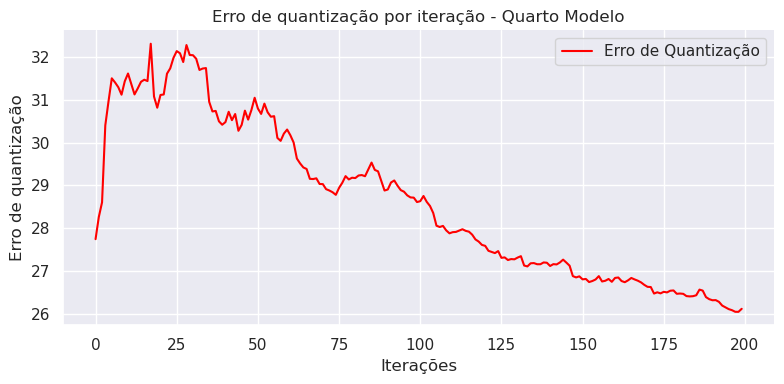

In [25]:
iteracoes = 200  # Número de iterações
q_erro = []  # Lista para armazenar o erro de quantização

# Treinamento e cálculo do erro de quantização
for i in range(iteracoes):
    rand = np.random.randint(len(dados_treino_2))  # Seleciona aleatoriamente uma amostra
    # Atualiza o modelo com a amostra aleatória
    quarto_modelo_som.update(dados_treino_2[rand], 
                             quarto_modelo_som.winner(dados_treino_2[rand]), 
                             i, iteracoes)
    # Calcula o erro de quantização
    q_erro.append(quarto_modelo_som.quantization_error(dados_treino_2))

# Plotagem do erro de quantização
plt.figure(figsize=(8, 4))
plt.plot(np.arange(iteracoes), q_erro, color='red', label='Erro de Quantização')
plt.ylabel('Erro de quantização')
plt.xlabel('Iterações')
plt.title('Erro de quantização por iteração - Quarto Modelo')
plt.legend()
plt.grid(True)
plt.tight_layout()